In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../data/raw/twitter_human_bots_dataset.csv')

In [5]:
df.head()

,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [6]:
print("Shape:", df.shape)
print("\nColumns and dtypes:\n")
print(df.dtypes)

Shape: (37438, 20)

Columns and dtypes:

Unnamed: 0                        int64
created_at                       object
default_profile                    bool
default_profile_image              bool
description                      object
favourites_count                  int64
followers_count                   int64
friends_count                     int64
geo_enabled                        bool
id                                int64
lang                             object
location                         object
profile_background_image_url     object
profile_image_url                object
screen_name                      object
statuses_count                    int64
verified                           bool
average_tweets_per_day          float64
account_age_days                  int64
account_type                     object
dtype: object


In [7]:
df = df.drop('Unnamed: 0', axis=1)
miss = df.isna().sum().sort_values(ascending=False)
miss_pct = (miss / len(df) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": miss, "missing_pct": miss_pct})
print(missing_table[missing_table['missing_count'] != 0])

                              missing_count  missing_pct
lang                                   7957        21.25
description                            7257        19.38
profile_background_image_url           4499        12.02
location                                  4         0.01
profile_image_url                         1         0.00


In [8]:
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Duplicate rows: 0


In [9]:
for c in df.columns:
    unique_vals = df[c].dropna().unique()
    if len(unique_vals) == 2 and df[c].dtype != bool:
        print(f"{c}: {unique_vals}")

account_type: ['bot' 'human']


In [10]:
print(df['account_type'].value_counts(dropna=False))

account_type
human    25013
bot      12425
Name: count, dtype: int64


In [11]:
df['target'] = df['account_type'].map({'human': 0, 'bot': 1})

In [12]:
class_count = df['target'].value_counts(dropna=False)
class_pct = df['target'].value_counts(normalize=True).round(3)
class_table = pd.DataFrame({
    "target": class_count.index.astype(str),
    "count": class_count.values,
    "proportion": class_pct.values
})
print(class_table)

  target  count  proportion
0      0  25013       0.668
1      1  12425       0.332


In [13]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [14]:
df['followers_friends_ratio'] = np.where(
    (df.get('followers_count', 0) != 0) & (df.get('friends_count', 0) != 0),
    df['followers_count'] / df['friends_count'],
    0
)

(df['followers_friends_ratio'] == 0).sum()

6631

In [15]:
df['description'] = df['description'].fillna("")
df['description_length'] = df['description'].astype(str).str.len()
df['has_description'] = df.get('description', '').astype(str).str.strip().ne('').astype(bool)

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

In [17]:
numeric_cols = [col for col in numeric_cols if col not in ['id', 'target']]
numeric_cols

['favourites_count',
 'followers_count',
 'friends_count',
 'id',
 'statuses_count',
 'average_tweets_per_day',
 'account_age_days',
 'target',
 'followers_friends_ratio',
 'description_length']

In [18]:
grouped_mean = df.groupby('target')[numeric_cols].mean().transpose().reset_index().rename(columns={"index":"feature"})
grouped_mean

['favourites_count',
 'followers_count',
 'friends_count',
 'statuses_count',
 'average_tweets_per_day',
 'account_age_days',
 'followers_friends_ratio',
 'description_length']

In [19]:
grouped_median = df.groupby('target')[numeric_cols].median().transpose().reset_index().rename(columns={"index":"feature"})
grouped_median

target,feature,0,1
0,favourites_count,16186.048455,4483.136740
1,followers_count,517747.512254,73500.273803
2,friends_count,4207.620677,4925.660443
3,statuses_count,21465.263223,20284.493521
4,average_tweets_per_day,6.712556,7.252241
5,account_age_days,3173.561308,2717.274930
6,followers_friends_ratio,12617.586749,2088.079968
7,description_length,76.756926,46.990825


In [20]:
# class 1 - class 0
means = df.groupby('target')[numeric_cols].mean()
mean_diff = (means.loc[1] - means.loc[0]).sort_values(key=abs, ascending=False)

mean_diff

target,feature,0,1
0,favourites_count,3649.000000,1131.000000
1,followers_count,1046.000000,25.000000
2,friends_count,474.000000,31.000000
3,statuses_count,7551.000000,2178.000000
4,average_tweets_per_day,2.410000,0.817000
5,account_age_days,3395.000000,2882.000000
6,followers_friends_ratio,1.282245,0.160714
7,description_length,74.000000,35.000000


In [21]:
# correlation with with target
corrs = df[numeric_cols + ['target']].corr()['target'].drop('target').sort_values(key=abs, ascending=False)
corrs

followers_count           -444247.238451
favourites_count           -11702.911714
followers_friends_ratio    -10529.506782
statuses_count              -1180.769702
friends_count                 718.039765
account_age_days             -456.286379
description_length            -29.766101
average_tweets_per_day          0.539685
dtype: float64

In [22]:
corr_features = corrs.abs().sort_values(ascending=False).head(6).index.tolist()
corr_features

description_length        -0.254421
account_age_days          -0.211960
favourites_count          -0.162448
followers_count           -0.084665
followers_friends_ratio   -0.012720
average_tweets_per_day     0.010339
statuses_count            -0.008258
friends_count              0.006825
Name: target, dtype: float64

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols + ['target']].corr(), 
            cmap="coolwarm", 
            annot=True, 
            center=0,
            linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


['description_length',
 'account_age_days',
 'favourites_count',
 'followers_count',
 'followers_friends_ratio',
 'average_tweets_per_day']

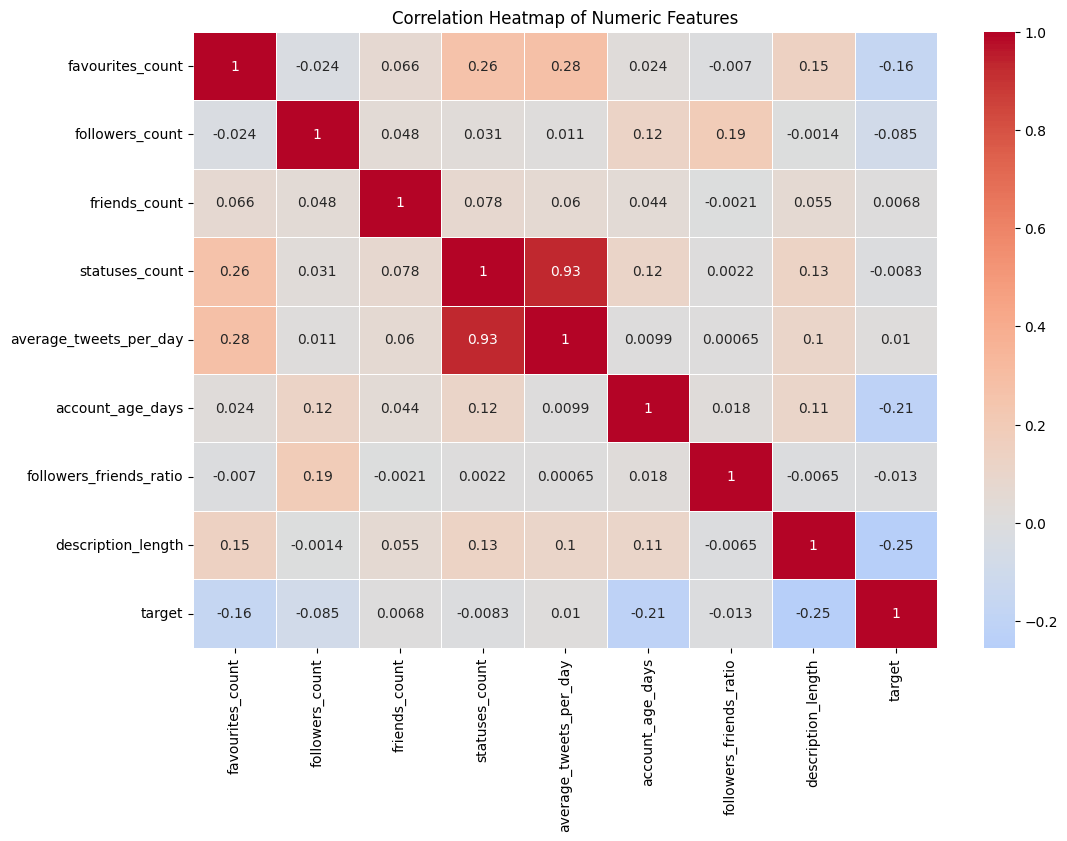

In [24]:
# histogram for correlated features
for feature in corr_features:
    if feature == 'followers_friends_ratio':
        continue
    
    plt.figure(figsize=(6,3.5))
    series = df[feature].dropna()
    if series.empty:
        continue
    series.hist(bins=40)
    plt.title(f"Histogram: {feature}")
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

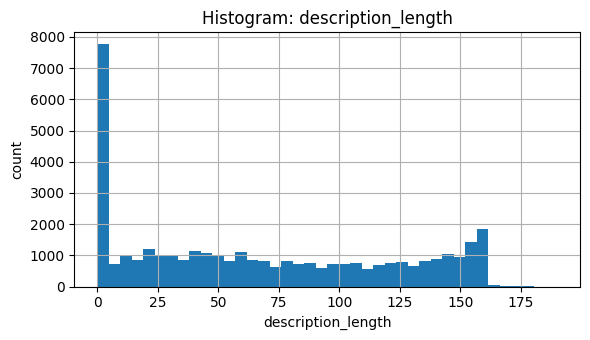

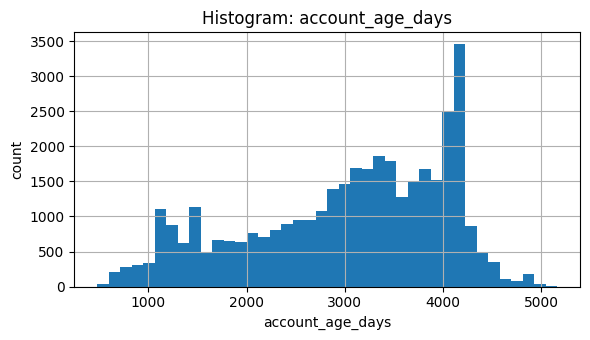

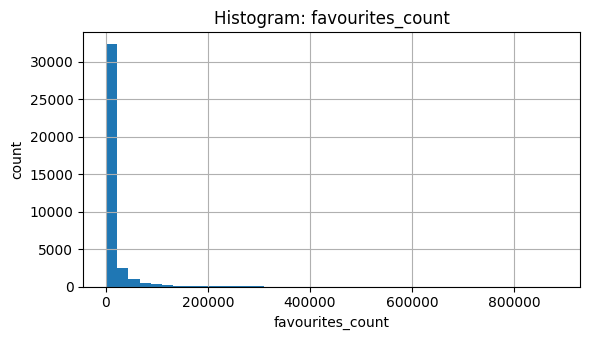

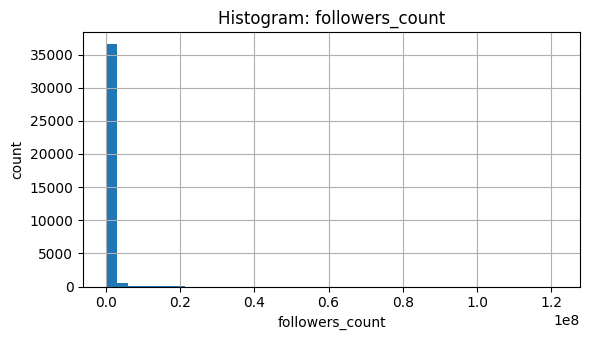

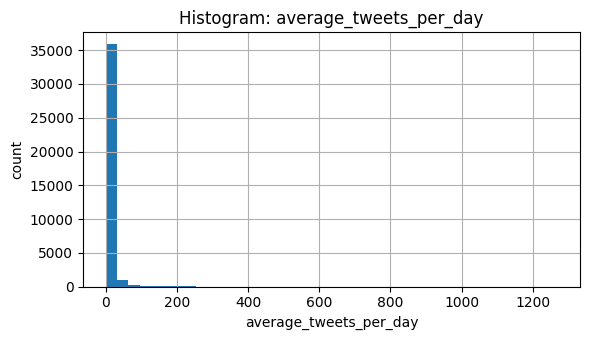

In [25]:
# boxplots split by target
for feat in corr_features:
    plt.figure(figsize=(6,3.5))
    groups = [df[df['target']==val][feat].dropna() for val in sorted(df['target'].dropna().unique())]
    if all(g.empty for g in groups):
        continue
    plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])
    plt.title(f"Boxplot of {feat} by target (0=human,1=bot)")
    plt.xlabel("target")
    plt.ylabel(feat)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\1184252905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])


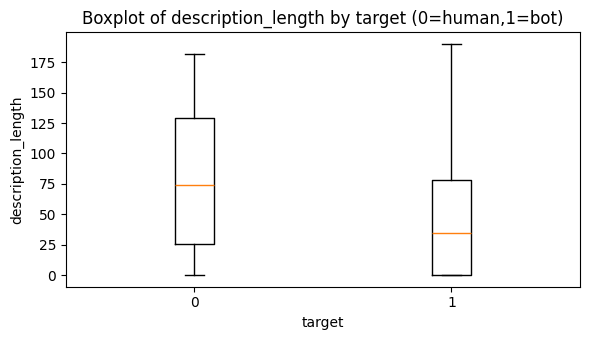

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\1184252905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])


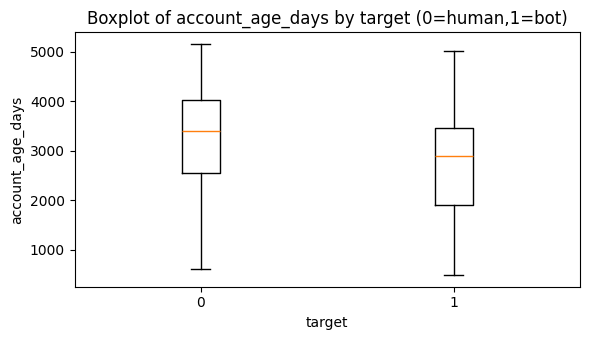

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\1184252905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])


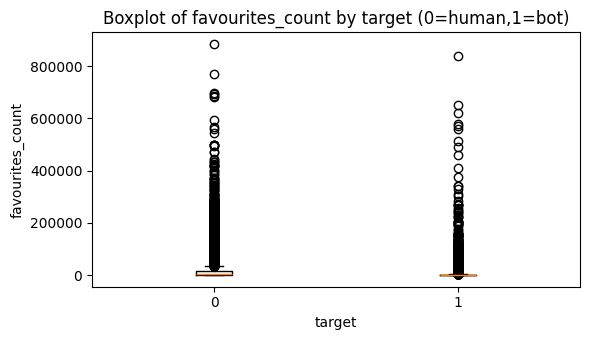

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\1184252905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])


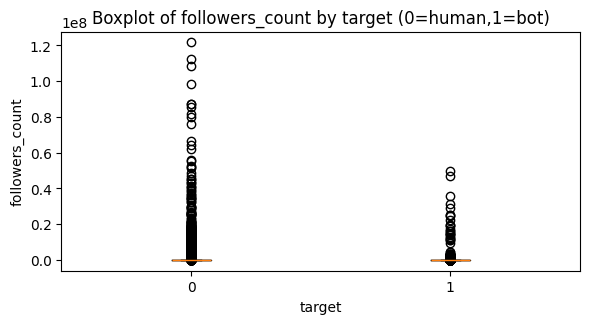

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\1184252905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])


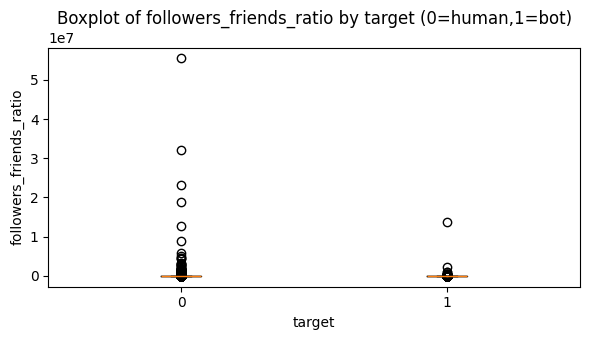

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\1184252905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(x) for x in sorted(df['target'].dropna().unique())])


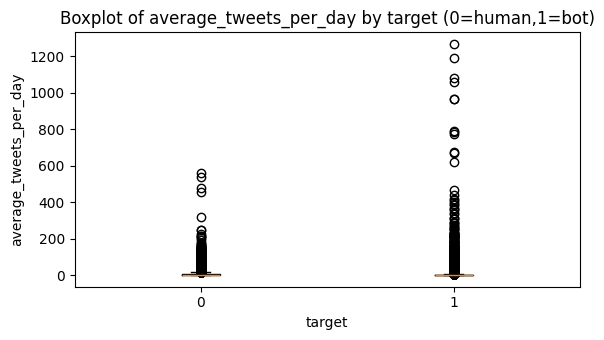

In [26]:
# features to transform
features = ['favourites_count','followers_count','followers_friends_ratio','average_tweets_per_day']
for f in features:
    if f in df.columns:
        # log transform
        df[f + '_log1p'] = np.log1p(pd.to_numeric(df[f], errors='coerce').fillna(0))

# boxplots on log scale
fig, ax = plt.subplots(1, len(features), figsize=(5*len(features),4))
for i, f in enumerate(features):
    col = f + '_log1p'
    if col in df.columns:
        ax[i].boxplot([df[df['target']==c][col].dropna() for c in sorted(df['target'].unique())],
                      labels=[str(c) for c in sorted(df['target'].unique())])
        ax[i].set_title(f'Boxplot of log1p({f})')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_812\2130265170.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot([df[df['target']==c][col].dropna() for c in sorted(df['target'].unique())],
C:\Users\Admin\AppData\Local\Temp\ipykernel_812\2130265170.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot([df[df['target']==c][col].dropna() for c in sorted(df['target'].unique())],
C:\Users\Admin\AppData\Local\Temp\ipykernel_812\2130265170.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot([df[df['target']==c][col].dropna() for c in sorted(df['target'].unique())],
C:\Users\Admin\AppD

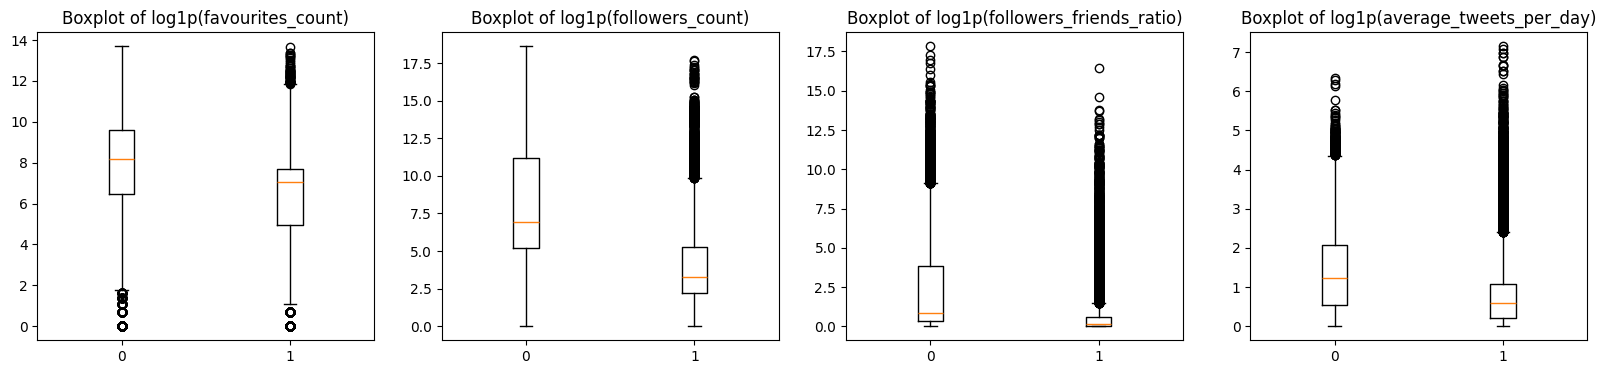

In [27]:
# categorical summaries and plots for categorical/boolean cols
cat_cols = [c for c in ['default_profile','default_profile_image','geo_enabled','verified', 'has_description'] if c in df.columns]
for c in cat_cols:
    vc = df[c].value_counts()
    cross = df.groupby(['target', c]).size().unstack(fill_value=0)
    prop = cross.div(cross.sum(axis=1), axis=0)
    prop.plot(kind='bar', stacked=True, figsize=(7,3.5))
    plt.title(f"Proportion by target and {c}")
    plt.xlabel("target")
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

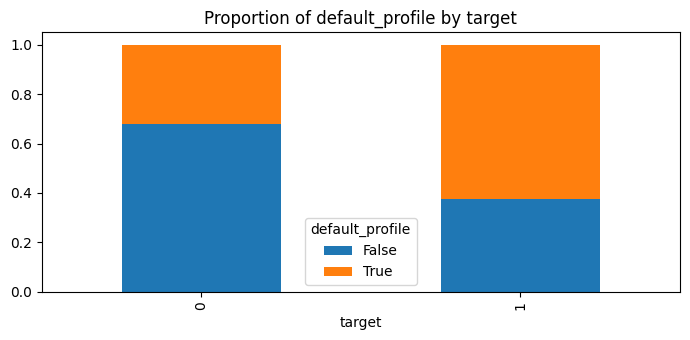

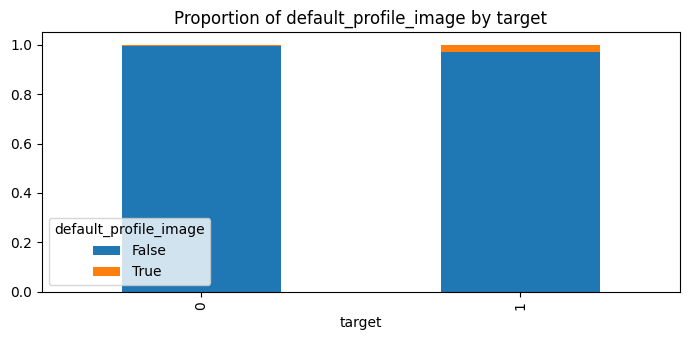

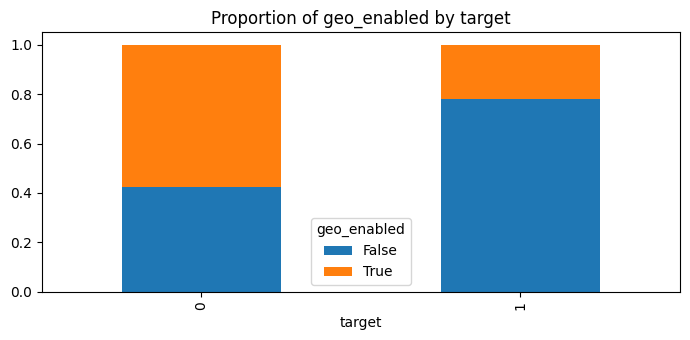

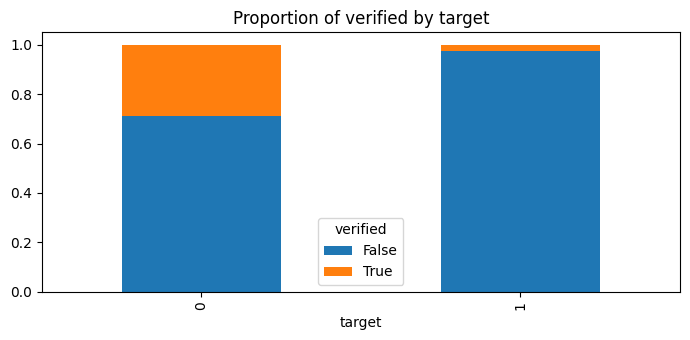

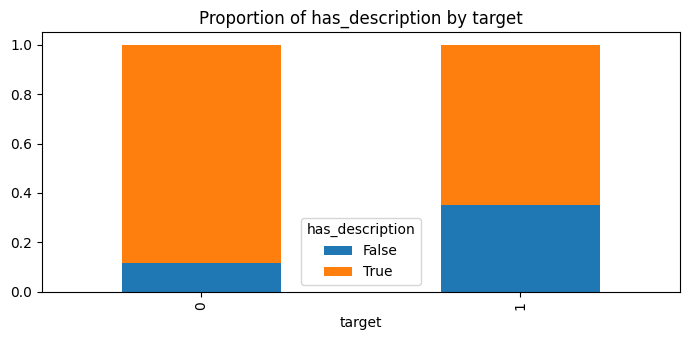

In [ ]:
# plots for categorical/boolean columns
cat_cols = [c for c in ['default_profile','default_profile_image','geo_enabled','verified', 'has_description'] if c in df.columns]
for c in cat_cols:
    vc = df[c].value_counts()
    cross = df.groupby(['target', c]).size().unstack(fill_value=0)
    prop = cross.div(cross.sum(axis=1), axis=0)
    prop.plot(kind='bar', stacked=True, figsize=(7,3.5))
    plt.title(f"Proportion of {c} by target")
    plt.xlabel("target")
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

Top 10 languages (overall):
lang
en    21450
es     1213
pt      704
it      637
ar      594
de      536
ja      378
fr      375
af      333
id      313
Name: count, dtype: int64

Counts by class (rows = class):
lang       en   es   pt   it   ar   de   ja   fr   af   id
target                                                    
0       16212  926  498  469  216  411  191  271  119  216
1        5238  287  206  168  378  125  187  104  214   97

Proportions by class:
lang       en     es     pt     it     ar     de     ja     fr     af     id
target                                                                      
0       0.830  0.047  0.026  0.024  0.011  0.021  0.010  0.014  0.006  0.011
1       0.748  0.041  0.029  0.024  0.054  0.018  0.027  0.015  0.031  0.014


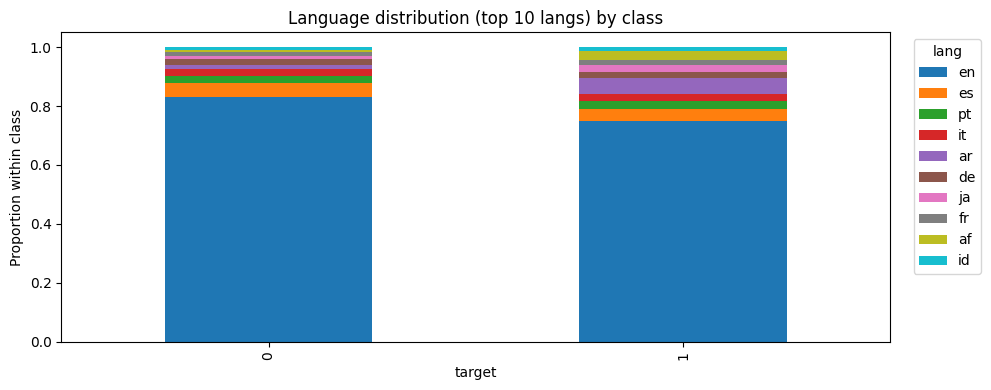

In [35]:
# top languages overall and by class
top_langs = df['lang'].value_counts().head(10)
top_lang_list = top_langs.index.tolist()

# counts by class for these top languages
lang_by_class = (
    df[df['lang'].isin(top_lang_list)]
      .groupby(['target', 'lang'])
      .size()
      .unstack(fill_value=0)
      .loc[:, top_lang_list]  
)

# proportions by class (rows sum to 1)
lang_by_class_prop = lang_by_class.div(lang_by_class.sum(axis=1), axis=0)

# show DataFrames 
print("Top 10 languages (overall):")
print(top_langs)
print("\nCounts by class (rows = class):")
print(lang_by_class)
print("\nProportions by class:")
print(lang_by_class_prop.round(3))

# stacked bar plot (proportions)
ax = lang_by_class_prop.plot(kind='bar', stacked=True, figsize=(10,4))
ax.set_ylabel('Proportion within class')
ax.set_xlabel('target')
ax.set_title('Language distribution (top 10 langs) by class')
plt.legend(title='lang', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()